* 本例展示如何在alpha-mind中使用深度学习模型。 
    - 为方便比较，使用的数据参数与[机器学习模型示例](https://github.com/alpha-miner/alpha-mind/blob/master/notebooks/Example%2012%20-%20Machine%20Learning%20Model%20Prediction.ipynb)一致。
    - 本例以Keras实现深度学习模型，故需要预装Keras。

* 请在环境变量中设置`DB_URI`指向数据库

In [1]:
%matplotlib inline

import os
import datetime as dt
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *
from keras.models import Sequential
from keras.layers import Dense 
from alphamind.model.modelbase import create_model_base

Using TensorFlow backend.


## 使用Keras构建模型（以线性回归为例）

### 构建Keras的接口模型

- alpha-mind中所有的模型算法都是通过底层接口模型实现的。在接口模型中都有统一的训练与预测方法，即*fit* 和 *predict*。
- 下面的代码就是创建一个接口类，使用Keras实现线性回归的算法。*fit* 和 *predict* 分别对应拟合与预测功能。

In [2]:
class LinearRegressionImpl(object):
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 0.01)
        self.training_epochs = kwargs.get('training_epochs', 10)
        self.display_steps = kwargs.get('display_steps', None)
        self.W = None
        self.b = None

    def result(self):
        with tf.Session() as sess:
            ret = [sess.run(self.W), sess.run(self.b)]
        return ret

    def fit(self, x, y):
        num_samples, num_features = x.shape

        output_dim = 1
        input_dim = num_features
        model = Sequential()
        model.add(Dense(output_dim, input_dim=input_dim, kernel_initializer='normal', activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(x, y, epochs=self.training_epochs, verbose=False)

        print('Optimization finished ......')
        self.model = model

    def predict(self, x):
        ret = self.model.predict(x)
        return np.squeeze(ret)

为了与alpha-mind的框架对接，还需要定义如下一个wrapper。这个wrapper需要实现*load* 和*save* 两种方法。

In [3]:
class LinearRegressionKS(create_model_base()):
    def __init__(self, features, fit_target, **kwargs):
        super().__init__(features=features, fit_target=fit_target)
        self.impl = LinearRegressionImpl(**kwargs)

    @classmethod
    def load(cls, model_desc: dict):
        return super().load(model_desc)

    def save(self):
        model_desc = super().save()
        model_desc['weight'] = self.impl.result()
        return model_desc


## 测试Keras模型
 
### 数据配置
------------

In [4]:
freq = '60b'
universe = Universe('zz800')
batch = 1
neutralized_risk = industry_styles
risk_model = 'short'
pre_process = [winsorize_normal, standardize]
post_process = [standardize]
warm_start = 3
data_source = os.environ['DB_URI']
horizon = map_freq(freq)

engine = SqlEngine(data_source)

我们使用当期的`roe_q`因子，来尝试预测未来大概一个月以后的`roe_q`因子。

* 训练的股票池为`zz800`;；
* 因子都经过中性化以及标准化等预处理；
* 预测模型使用线性模型，以20个工作日为一个时间间隔，用过去4期的数据作为训练用特征。

In [5]:

kernal_feature = 'ROE'
regress_features = {kernal_feature: LAST(kernal_feature),
                    kernal_feature + '_l1': SHIFT(kernal_feature, 1),
                    kernal_feature + '_l2': SHIFT(kernal_feature, 2),
                    kernal_feature + '_l3': SHIFT(kernal_feature, 3)
                   }
fit_target = [kernal_feature]

data_meta = DataMeta(freq=freq,
                     universe=universe,
                     batch=batch,
                     neutralized_risk=neutralized_risk,
                     risk_model=risk_model,
                     pre_process=pre_process,
                     post_process=post_process,
                     warm_start=warm_start,
                     data_source=data_source)

regression_model_ks = LinearRegressionKS(features=regress_features, fit_target=fit_target, training_epochs=400)
regression_composer_ks = Composer(alpha_model=regression_model_ks, data_meta=data_meta)

## 模型对比（sklearn线性回归模型 v.s. keras线性回归模型）： IC 系数
------------------

### model train and predict
- train: 给定ref_date, 模型提取ref_date之前的所有训练日期的因子数据，以及ref_date当日的收益率数据进行训练。
- predict: 给定ref_date, 模型提取ref_date当日的因子数据，预测下一期的收益率数据。
- ic：给定ref_date, 模型用预测的结果与下一期真实的收益率数据求相关性。

In [9]:
ref_date = '2011-01-01'
ref_date = adjustDateByCalendar('china.sse', ref_date).strftime('%Y-%m-%d')

In [10]:
regression_model_sk = LinearRegression(features=regress_features, fit_target=fit_target)
regression_composer_sk = Composer(alpha_model=regression_model_sk, data_meta=data_meta)

In [17]:
%%time

regression_composer_sk.train(ref_date)
regression_composer_ks.train(ref_date)
print("\nSklearn Regression Testing IC: {0:.4f}".format(regression_composer_sk.ic(ref_date=ref_date)[0]))
print("Keras Regression Testing IC: {0:.4f}".format(regression_composer_ks.ic(ref_date=ref_date)[0]))

Optimization finished ......

Sklearn Regression Testing IC: 0.9434
Keras Regression Testing IC: 0.9439
Wall time: 29.2 s


## 回测（ simple long short strategy）
--------------------------

### 策略的初始化

#### 加载数据： fetch_data_package
- 因子数据
- 行业数据
- 风险模型数据
- 数据的预处理

In [14]:
start_date = '2011-01-01'
end_date = '2012-01-01'

data_package2 = fetch_data_package(engine,
                                   alpha_factors=regress_features,
                                   start_date=start_date,
                                   end_date=end_date,
                                   frequency=freq,
                                   universe=universe,
                                   benchmark=906,
                                   warm_start=warm_start,
                                   batch=1,
                                   neutralized_risk=neutralized_risk,
                                   pre_process=pre_process,
                                   post_process=post_process)

model_dates = [d.strftime('%Y-%m-%d') for d in list(data_package2['predict']['x'].keys())]


industry_name = 'sw_adj'
industry_level = 1

industry_names = industry_list(industry_name, industry_level)
industry_total = engine.fetch_industry_matrix_range(universe, dates=model_dates, category=industry_name, level=industry_level)

2019-02-10 01:21:24,492 - ALPHA_MIND - INFO - Starting data package fetching ...
2019-02-10 01:21:25,503 - ALPHA_MIND - INFO - factor data loading finished
2019-02-10 01:21:31,384 - ALPHA_MIND - INFO - fit target data loading finished
2019-02-10 01:21:31,672 - ALPHA_MIND - INFO - industry data loading finished
2019-02-10 01:21:31,881 - ALPHA_MIND - INFO - benchmark data loading finished
2019-02-10 01:21:32,966 - ALPHA_MIND - INFO - data merging finished
2019-02-10 01:21:33,066 - ALPHA_MIND - INFO - Loading data is finished
2019-02-10 01:21:33,096 - ALPHA_MIND - INFO - Data processing is finished


#### 运行策略：（sklearn线性回归模型 v.s.keras线性回归模型）

In [15]:
rets1 = []
rets2 = []



for i, ref_date in enumerate(model_dates):
    py_ref_date = dt.datetime.strptime(ref_date, '%Y-%m-%d')
    industry_matrix = industry_total[industry_total.trade_date == ref_date]
    dx_returns = pd.DataFrame({'dx': data_package2['predict']['y'][py_ref_date].flatten(),
                               'code': data_package2['predict']['code'][py_ref_date].flatten()})
    
    res = pd.merge(dx_returns, industry_matrix, on=['code']).dropna()
    codes = res.code.values.tolist()
    
    alpha_logger.info('{0} full re-balance: {1}'.format(ref_date, len(codes)))
    
    ## sklearn regression model
    
    raw_predict1 = regression_composer_sk.predict(ref_date, x=data_package2['predict']['x'][py_ref_date])[0].loc[codes]
    er1 = raw_predict1.fillna(raw_predict1.median()).values
    
    target_pos1, _ = er_portfolio_analysis(er1,
                                           res.industry_name.values,
                                           None,
                                           None,
                                           False,
                                           None,
                                           method='ls')
        
    target_pos1['code'] = codes
    result1 = pd.merge(target_pos1, dx_returns, on=['code'])
    ret1 = result1.weight.values @ (np.exp(result1.dx.values) - 1.)
    rets1.append(np.log(1. + ret1))

    ## keras regression model
    
    raw_predict2 = regression_composer_ks.predict(ref_date, x=data_package2['predict']['x'][py_ref_date])[0].loc[codes]
    er2 = raw_predict2.fillna(raw_predict2.median()).values
    
    target_pos2, _ = er_portfolio_analysis(er2,
                                           res.industry_name.values,
                                           None,
                                           None,
                                           False,
                                           None,
                                           method='ls')
    
    target_pos2['code'] = codes
    result2 = pd.merge(target_pos2, dx_returns, on=['code'])
    ret2 = result2.weight.values @ (np.exp(result2.dx.values) - 1.)
    rets2.append(np.log(1. + ret2))
    ## perfect forcast
    
    alpha_logger.info('{0} is finished'.format(ref_date))

2019-02-10 01:22:04,566 - ALPHA_MIND - INFO - 2011-01-04 full re-balance: 789
D:\ProgramData\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
D:\ProgramData\anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
2019-02-10 01:22:04,625 - ALPHA_MIND - INFO - 2011-01-04 is finished
2019-02-10 01:22:04,640 - ALPHA_MIND - INFO - 2011-04-07 full re-balance: 779
D:\ProgramData\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
Passing list-lik

#### 收益图对比

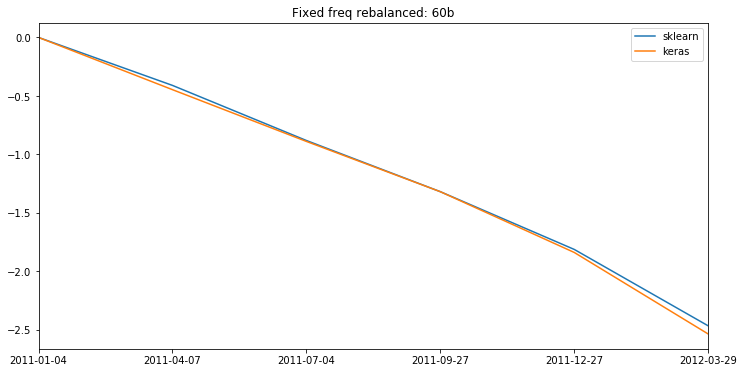

In [16]:
ret_df = pd.DataFrame({'sklearn': rets1, 'keras': rets2}, index=model_dates)
ret_df.loc[advanceDateByCalendar('china.sse', model_dates[-1], freq).strftime('%Y-%m-%d')] = 0.
ret_df = ret_df.shift(1)
ret_df.iloc[0] = 0.

ret_df[['sklearn', 'keras']].cumsum().plot(figsize=(12, 6),
                                             title='Fixed freq rebalanced: {0}'.format(freq))